<a href="https://colab.research.google.com/github/riteshms/NLP-with-Python/blob/master/pynini_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite State Transducers with Pynini

Today we will use the Pynini Python package for working with finite state transducers.


In [ ]:
! pip install pynini

     |████████████████████████████████| 161.1 MB 3.5 kB/s 


In [ ]:
import pynini as pn

Let's first try creating some finite state acceptors.

A single acceptor transission can be created using the pynini.accep() function.

A repeated state can be specified using `closure()`. Just `closure(fst)` means "repeat zero or more times", `closure(fst, n)` means "repeat at least n times, and `closure(fst, m, n)` means "repeat m to n times".

Let's create a FSA for the regular expression `a*bbc+`:

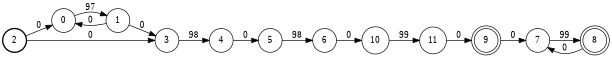

In [ ]:
fsa1 = (pn.closure(pn.accep("a")) + pn.accep("b") + pn.accep("b") + pn.closure(pn.accep("c"), 1))
fsa1

As we see, the arcs have currently numerical labels. THis is because Pynini automatically converts (by default) the user-provided acceptor symbols into their UTF-8 codes. To see the actual symbols on the arcs in Jupyter notebooks, we need to create a so-called symbol table (a mapping between strings and numbers), and attach it to the FSA:

In [ ]:
ascii_table = pn.SymbolTable()
ascii_table.add_symbol("<eps>", 0)
for i in range(12, 128):
  ascii_table.add_symbol(chr(i), i)


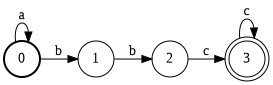

In [ ]:
fsa1.set_input_symbols(ascii_table)

We'll make a quick function that adds the symbol table to the FST and returns it, so that it can be easily done every time we want to visualize the FST.

In [ ]:
def draw(fst, symbol_table=ascii_table):
  fst.set_input_symbols(symbol_table)
  fst.set_output_symbols(symbol_table)
  return fst


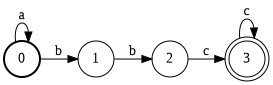

In [ ]:
draw(fsa1)

The FSA that is created as a result of many atomic FSA operations is not optimal: it has more transisions and states than needed. The `optimize()` function makes it optimal, and easier to understand:

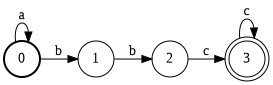

In [ ]:
draw(pn.optimize(pn.closure(pn.accep("a")) + pn.accep("b") + pn.accep("b") + pn.closure(pn.accep("c"), 1)))


Let's now test what kind of strings does this FSA accept. Use the pynini.lib.rewrite.matches() function for this. It checks, whether the FST given as a 3rd argument transforms input string (or FST) to the given output string (or FST).

In [ ]:
import pynini.lib.rewrite as pn_rewrite

pn_rewrite.matches("abbc", "abbc", fsa1)

True

If the FSA doesn't accept the input string, an exception occurs:

In [ ]:
pn_rewrite.matches("abc", "abc", fsa1)

Error: ignored

The sequence `p.a("b") + p.a("b")` can be also written in shorthand form, using `p.a("bb")`:

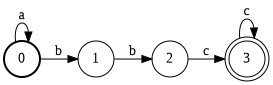

In [ ]:
fsa1 = pn.optimize(pn.closure(pn.accep("a")) + pn.accep("bb") + pn.closure(pn.accep("c"), 1))
draw(fsa1)

More about the closure() method:

The following are the equivalents for the closure-style syntax used in
Perl-style regular expressions:

    Regexp:             This method:            Copy shortcuts:

    /x?/                x.closure(0, 1)         x.ques
    /x*/                x.closure()             x.star
    /x+/                x.closure(1)            x.plus
    /x{N}/              x.closure(N, N)
    /x{M,N}/            x.closure(M, N)
    /x{N,}/             x.closure(N)
    /x{,N}/             x.closure(0, N)

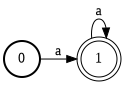

In [ ]:
draw(pn.optimize((pn.accep("a").plus)))

Let's try with another FSA that we looked at in the lecture. It should accept US money amounts, e.g. `one dollar`, `one dollar fifty cents`, etc.

But let's start from a one that recognizes simpler dollar expressions, like "two dollars".

First, we have to define a FSA that accepts digits: "one", or "two", etc. We'll use the pynini `union()` or creating the set of alternative digits.

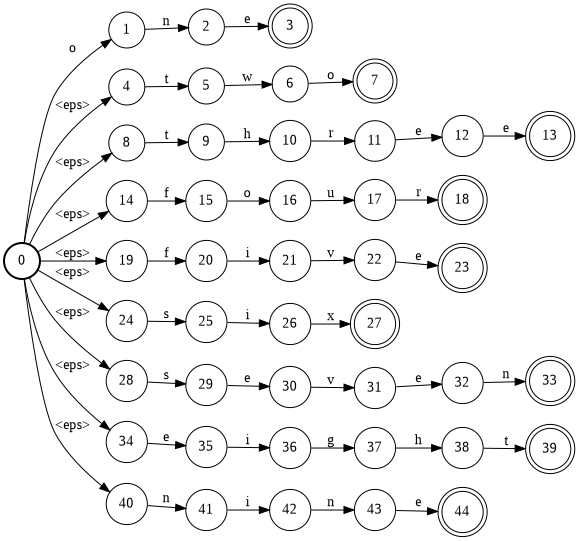

In [ ]:
a_1_to_9 = pn.union("one", "two", "three", "four", "five", "six", "seven", "eight", "nine")
draw(a_1_to_9)

As you see, more complex FSAs quickly become quite difficult to understand based on their graphic representation.
Optimizing it doesn't really help:

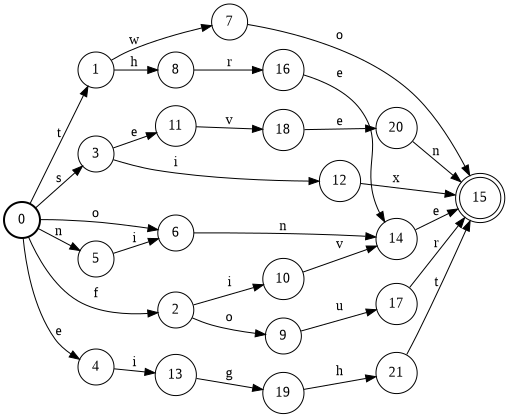

In [ ]:
a_1_to_9.optimize()

Let's do a quick check what this FSA accepts. Instead of using the `matches` function, we just simply "send" the input string through the FSA. If it is accepted by the FSA, a new "linear" FSA that corresponds to the actual path taken is returned.

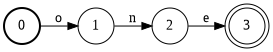

In [ ]:
draw("one" @ a_1_to_9)

In [ ]:
draw("foo" @ a_1_to_9)

OK, let's try to add dollars and cents:

In [ ]:
a_1_to_9_dollars = (a_1_to_9 + " dollars")

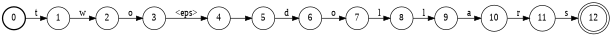

In [ ]:
draw("two dollars" @ a_1_to_9_dollars)

Of course it's not really optimal, as it also accepts "one dollars", instead of "one dollar". Let's fix it:

In [ ]:
a_2_to_9 = pn.union("two", "three", "four", "five", "six", "seven", "eight", "nine")
dollars = pn.union("one dollar", a_2_to_9 + " dollars")

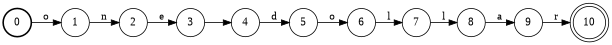

In [ ]:
draw("one dollar" @ dollars)

In [ ]:
draw("one dollars" @ dollars)

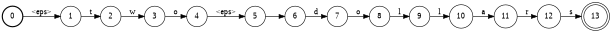

In [ ]:
draw("two dollars" @ dollars)

But the money amount can also have cents. It can actually consist of only cents, like "two cents". Or only from dollars, or from both, like "one dollar two cents". But it shouldn't be empty.

In [ ]:
cents = pn.union("one cent", a_2_to_9 + " cents")

In [ ]:
money = pn.union(dollars, cents, dollars + " " + cents)

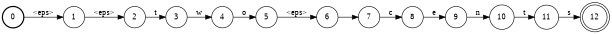

In [ ]:
draw("two cents" @ money)

In [ ]:
draw("two dollars one cent" @ money)

The resulting FSA is already now quite complex:

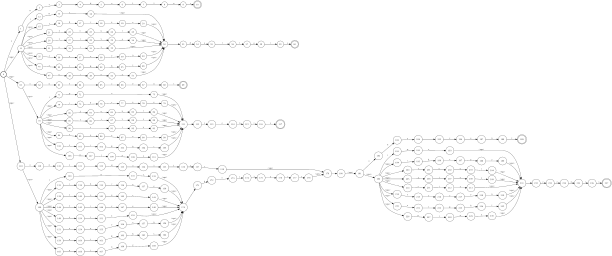

In [ ]:
draw(money)

Actually, it's complex because it deals with characters, not words. We can simplify it a bit if we make the transissions accepts whole tokens, instead of characters. Pynini allows it if you put the tokens in square brackets. In this case, Pynini auotamtically generates a new numerical ID for each symbol given as "[foo]". We also need to attach this generated symbol table to the FST when drawing it (see last line).

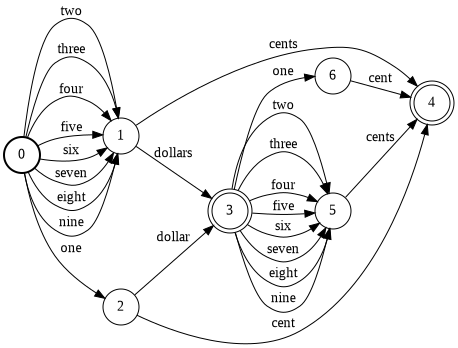

In [ ]:
a_2_to_9_words = pn.union("[two]", "[three]", "[four]", "[five]", "[six]", "[seven]", "[eight]", "[nine]")
dollars_words = pn.union("[one][dollar]", a_2_to_9_words + "[dollars]")
cents_words = pn.union("[one][cent]", a_2_to_9_words + "[cents]")
money_words = pn.union(dollars_words, cents_words, dollars_words + cents_words).optimize()
money_words.set_input_symbols(pn.generated_symbols())

The above picture looks already much nicer! Note that the test string must then also be tokenized, with tokens surrounded by square brackets:

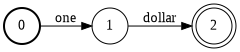

In [ ]:
draw("[one][dollar]" @ money_words, pn.generated_symbols())

One way to debug FSTs is to  generate random output, by selecting random paths from it's start state until the end state:

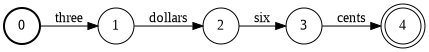

In [ ]:
pn.randgen(money_words)

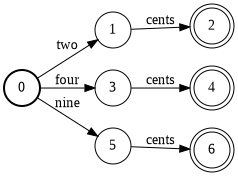

In [ ]:
pn.randgen(money_words, 3)

The task of making this FSA to accept more complex amounts, like "twenty one dollars thirteen cents" is left for the students.

#### Excercise

Construct a FSA that accepts English (or Estonian) numbers from 0 to 99, given as words, e.g. `[twenty] [one]`. Try to be economical, don't just list all possible 100 variants

Let's try to construct a naive FSA that accepts a very limited set of English nouns, like dog, cat, mouse, dogs, mice sheep, etc.

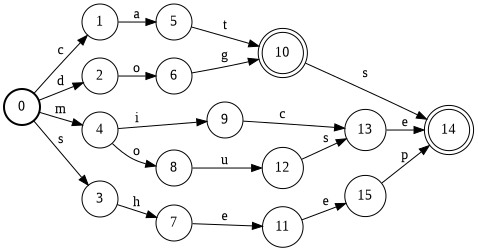

In [ ]:
reg_noun = pn.union("dog", "cat")
irreg_noun_sg = pn.union("mouse", "sheep")
irreg_noun_pl = pn.union("mice", "sheep")
nouns = pn.union(reg_noun, reg_noun + "s", irreg_noun_sg, irreg_noun_pl).optimize()
draw(nouns)

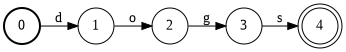

In [ ]:
draw("dogs" @ nouns)

In [ ]:
draw("mouses" @ nouns)

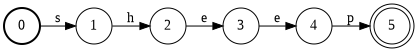

In [ ]:
pn.randgen(nouns)

In [ ]:
pn.randgen(nouns).string()

'dogs'

#### Exercise:
Create a FST that accepts Estonian nouns with at least 3 words and 3 inflections. The words are karu, laud, vahvel, and the inflections are nimetav (karu - laud - vahvel), omastav (karu - laua - vahvli) and kaasaütlev (karuga - lauaga - vahvliga). Try to reuse parts omastav when constructing kaasaütlev, instead of just listing all nine varints of the words. That is, it should be easy to extend this FSA to understand new inflections.

## Transducers

So far, we looked at acceptors. Transducers are like acceptors, but every arc has input and output symbols, instead of just input symbols. Note that by default, output symbols are equal to input symbols. So, actually every FSA is also an FST.

A transducer arc is constucted using Pynini's cross() function. It takes two arguments: input and output symbols.


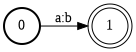

In [ ]:
draw(pn.cross("a", "b"))

Lets's  construct a FST that accepts a string "aabdd" and changes it into "aacdd":

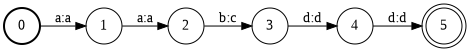

In [ ]:
fst0 = (pn.accep("aa") + pn.cross("b", "c") + pn.accep("dd")).optimize()
draw(fst0)

Let's look at something more complicated.

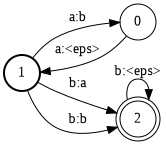

In [ ]:
fst1 = (pn.cross("aa", "b").closure() + pn.union(pn.cross("b", "a"), pn.accep("b")) + pn.cross("b", "").closure()).optimize()
draw(fst1)

Let's test:

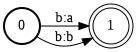

In [ ]:
draw("b" @ fst1)

We saw that the result of composing a string "b" with the FST is actually ambiguous: there are two paths, one resulting in output "a" and the other one in "b". This is because the FST is non-deterministic: it has to arcs from state 1 to state 2, both with input "b". The ambiguous result is conveniently represented as an FST.

To get the possible outputs as strings, use the paths() method of the resulting FST, and the `ostrings()` method or the resulting path iterator:

In [ ]:
list(("b" @ fst1).paths().ostrings())

['a', 'b']

In [ ]:
def all_paths(fst):
    return list(fst.paths().ostrings())

all_paths("b" @ fst1)

['a', 'b']

Let's play some more with this FST:

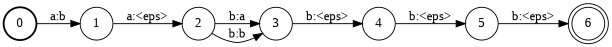

In [ ]:
draw("aabbbb" @ fst1)

In [ ]:
all_paths("aabbbb" @ fst1)

['ba', 'bb']

We learned in the lecture that FST can be inverted. The inversion of a transducer switches the input and output labels:

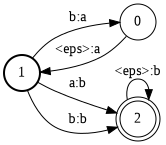

In [ ]:
fst1_invert = pn.invert(fst1)
fst1_invert

The inverse FST should apply the inverse mapping. I.e., if the original FST converts from "b" to "a", then the inverse should convert from "a" to "b". Let's try:

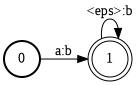

In [ ]:
draw("a" @ fst1_invert)

In [ ]:
all_paths("a" @ fst1_invert)

FstOpError: ignored

We got an error, because there is an infinite number of outputs that correspond to input "a": b, bb, bbbbbbbb, etc, (Do you see why? Note that arc `<epsilon>:b` from the final state? We can take this arc any number of times). We can use the `pynini.shortestpath(fst, nshortest=10)` function to select 10 shortest paths from the resulting FST. Note that "shortest" here means shortest in the FST sense, i.e., the paths with the minimum *cost*. Since all our paths have a cost of zero (since we haven't added any weights to them), all paths have the same cost, and `shortestpath()` selects random paths:

In [ ]:
list((pn.shortestpath("a" @ fst1_invert, nshortest=10)).paths().ostrings())

['bbbbbbbb',
 'bbbbbbbbb',
 'bbbbbbbbbb',
 'bbbb',
 'bbbbb',
 'bbbbbb',
 'bbb',
 'bb',
 'bbbbbbb',
 'b']

Let's make a new function top10_paths function actually do that:

In [ ]:
def top10_paths(fst):
    return list(pn.shortestpath(fst, nshortest=10).paths().ostrings())

top10_paths("a" @ fst1_invert)

['bbbbbbbb',
 'bbbbbbbbb',
 'bbbbbbbbbb',
 'bbbb',
 'bbbbb',
 'bbbbbb',
 'bbb',
 'bb',
 'bbbbbbb',
 'b']

Let's now try do do some simple morphological analysis using FSTs.

We look at the Estonian words ratsu, kõne, male. They all infect in the same way:
  * Nominative: ratsu, kõne, male
  * Genitive: ratsu, kõne, male
  * Partitive: ratsut, kõnet, malet
  * Illative: ratsusse, kõnesse, malesse
  
The FST should accept all the above words in the four inflections, and output the word in Nominative case, with a an appended infection marker, e.g.: ratsusse -> ratsu /ill/, kõnet -> kõne /p/.

Let's first try to define the stems, and a transducer for nominative inflection:

In [ ]:
stems = pn.union("ratsu", "kõne", "male")
nominative = stems + pn.cross("", " /nom/")

In [ ]:
top10_paths("ratsu" @ nominative)

['ratsu /nom/']

Let's also define transducers for other infections.

In [ ]:
genitive = stems + pn.cross("", " /gen/")
partitive = stems + pn.cross("t", " /p/")
illative = stems + pn.cross("sse", " /ill/")

wordform_to_analysis = pn.union(nominative, genitive, partitive, illative)

We can see that now the word `ratsu` has actually two ambiguous analyses, because `ratsu` can be either nominative or genitive -- both use the same word form:

In [ ]:
top10_paths("ratsu" @ wordform_to_analysis)

['ratsu /nom/', 'ratsu /gen/']

In [ ]:
top10_paths("kõnesse" @ wordform_to_analysis)[0]

'kõne /ill/'

One of the nice things about FSTs is that they can be inverted, as we already learned. But it turns out that this is really useful in the context of morphological analysis. If we invert a FST that does morphological analysis, we get a FST that does morpholgical generation! Let's try:

In [ ]:
analysis_to_wordform = pn.invert(wordform_to_analysis)
top10_paths("male /ill/" @ analysis_to_wordform)

['malesse']

Now, we will learn about one of the most useful FST operations, the context-dependent rewrite operation.

For example, the FST below transforms b to c when b occurs between a and d

For example: abbabdc -> abbacdc

The standard notation for this is: b → c/a___d

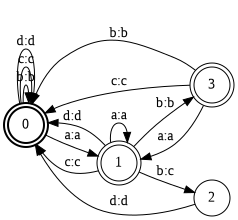

In [ ]:
rewrite_fst = pn.cdrewrite(pn.cross("b", "c"), "a", "d", pn.union(*"abcd").closure()).optimize()
draw(rewrite_fst)

Note that the last argument to cdrewrite, `pn.union(*"abcd").closure()` must be a cyclic, unweighted acceptor representing the closure over the alphabet. I.e., it represents all the possible strings that can be input to cdrewrite. Let's check what this FST does:

In [ ]:
top10_paths("abd" @ rewrite_fst)

['acd']

In [ ]:
top10_paths("abbabdc" @ rewrite_fst)

['abbacdc']

If the left context and right context do not match, it doesn't do anything.

In [ ]:
top10_paths("b" @ rewrite_fst)

['b']

We may leave the right (or left) context empty, then this context is not checked:

In [ ]:
rewrite_fst2 = pn.cdrewrite(pn.cross("b", "c"), "a", "", pn.union(*"abcd").closure()).optimize()
top10_paths("abbbaa" @ rewrite_fst2)

['acbbaa']

Note that the left context and right context do not need to be strings -- they can be any acceptors. For example, let's modify the rewrite FST so that it replaces "b" with "c" if "a" is seen *anywhere* before the "c", not necessarily immidiately before it:

In [ ]:
rewrite_fst3 = pn.cdrewrite(pn.cross("b", "c"), "a" + pn.union(*"abcd").closure(), "", pn.union(*"abcd").closure()).optimize()
top10_paths("ab" @ rewrite_fst3)

['ac']

In [ ]:
top10_paths("cccb" @ rewrite_fst3)

['cccb']

In [ ]:
top10_paths("acccb" @ rewrite_fst3)

['acccc']

The cdrewrite function is useful for making a morphological analyzer more flexible. Let's try to make an analyzer for the Estonian words vahvel, noobel, number. They inflect as:

  * Nominative: vahvel, noobel, number
  * Genitive: vahvli, noobli, numbri
  * Partitive: vahvlit, nooblit, numbrit
  * Illative: vahvlisse, nooblisse, numbrisse
  
THose words are more complicated because different inflections are not a result of just adding a suffix to the nominative stem (as with the word "ratsu") -- the stem also changes from "vahvel" to "vahvl".

Let's first make a FST that can inflect all words based on the ending, where the ending is seperated by "^":

In [ ]:
words = ["number", "vahvel", "noobel"]
end_analyzer = pn.string_map(words) + pn.union(pn.cross("^it", " /part/"), pn.cross("^isse", " /ill/"), pn.cross("^i", " /gen/"), pn.cross("", " /nom/")).optimize()

This FST can analyze words where the ending has been properly seperated:

In [ ]:
top10_paths("number^i" @ end_analyzer)

['number /gen/']

Now let's create another FST that can transform "numbri" to "number^i" and "vahvli" to "vahvel^i":

In [ ]:
sigma_star = pn.union(*"abdefghjiklmnoprstuvõäöüxy^").closure()
stem_change = pn.cdrewrite(pn.union(pn.cross("li", "el^i"), pn.cross("ri", "er^i")), "", pn.union("", "s", "sse", "ga") + "[EOS]", sigma_star).optimize()

top10_paths("numbri" @ stem_change)

['number^i']

The stem change li -> el^i, ri -> er^i is only applied if the left context is "[EOS]", "s[EOS]", "sse[EOS]", etc. Here [EOS] is Pynini's special symbol for the end-of-string. This is needed because we don't want any other occurrences of "li" to be replaced, e.g. "ribambri" should be changed to "ribamber^i", not "er^ibamber^i". Let's check:

In [ ]:
top10_paths("ribambri" @ stem_change)

['ribamber^i']

And now, we can put the two FSTs together, by composing them:

In [ ]:
wordform_to_analysis2 = stem_change @ end_analyzer

top10_paths("numbri" @ wordform_to_analysis2)

['number /gen/']

Can we invert it, as we did before with the simpler analyzer?

In [ ]:
analysis_to_word2 = pn.invert(wordform_to_analysis2)

In [ ]:
top10_paths("number /gen/" @ analysis_to_word2)

['number^i', 'numbri']

What happened? Why is 'number^i' also returned as a possible word form? This is because the cdrewrite operation is optional. Actually, when we analyze 'number^i' with our analysis_to_word2, it should happily analyze it (which is of course a problem):

In [ ]:
top10_paths("number^i" @ wordform_to_analysis2)

['number /gen/']

In order to fix this, we have to change our FST so that it wouldn't even accept a string containing "^". We can do it by just putting an acceptor before everything, that doesn't accept a string containing "^":

In [ ]:
valid_chars = pn.union(*"abdefghjiklmnoprstuvõäöüxy").closure().optimize()
wordform_to_analysis2 = (valid_chars @ stem_change @ end_analyzer)
top10_paths("numbri" @ wordform_to_analysis2)

['number /gen/']

In [ ]:
top10_paths("number^i" @ wordform_to_analysis2)

[]

In [ ]:
analysis_to_word2 = pn.invert(wordform_to_analysis2)
top10_paths("number /gen/" @ analysis_to_word2)

['numbri']

We can now even put our two analyzers together:

In [ ]:
composite_wordform_to_analysis = pn.union(wordform_to_analysis, wordform_to_analysis2)

In [ ]:
top10_paths("numbri" @ composite_wordform_to_analysis)

['number /gen/']

In [ ]:
top10_paths("ratsu" @ composite_wordform_to_analysis)

['ratsu /nom/', 'ratsu /gen/']

As before, we can use random generation to check whether the big FST generates only valid output

In [ ]:
for w in (top10_paths(pn.randgen(composite_wordform_to_analysis, 5))): print(w)

kõne /p/
male /p/
kõne /p/
vahvel /gen/
kõne /nom/


Finally, a remark that you might need in your homework. It's important to understand you can transduce "something" from "nothing". For example, you can use the following transducer for put spaces between each character (see how `pn.t("", " ")` transduces empty string sto space):

In [ ]:
one_character = pn.union(*"abdefghjiklmnoprstuvõäöüxy")
spacer = (one_character +  pn.cross("", " ")).closure() + one_character

In [ ]:
("test" @ spacer).string()

't e s t'